## Medical Paper Reconmmendation System via Reranker RAG

### 1. Load the data from HuggingFace

In [7]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from 
ds = load_dataset("MedRAG/pubmed")

# Get the train data， first 10k samples
train_data = ds['train']

df = pd.DataFrame(train_data[:10000])

# Save the whole train data to a csv file
df.to_csv('train.csv', index=False)

### 2. Data cleaning

In [8]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')

In [9]:
data_raw = pd.read_csv('train.csv')

In [10]:
data_raw.head()

,id,title,content,contents,PMID
0,pubmed23n0001_0,[Biochemical studies on camomile components/II...,(--)-alpha-Bisabolol has a primary antipeptic ...,[Biochemical studies on camomile components/II...,21
1,pubmed23n0001_1,[Demonstration of tumor inhibiting properties ...,A report is given on the recent discovery of o...,[Demonstration of tumor inhibiting properties ...,22
2,pubmed23n0001_2,Effect of etafenone on total and regional myoc...,The distribution of blood flow to the subendoc...,Effect of etafenone on total and regional myoc...,23
3,pubmed23n0001_3,Influence of a new virostatic compound on the ...,"The virostatic compound N,N-diethyl-4-[2-(2-ox...",Influence of a new virostatic compound on the ...,24
4,pubmed23n0001_4,Pharmacological properties of new neuroleptic ...,"RMI 61 140, RMI 61 144 and RMI 61 280 are newl...",Pharmacological properties of new neuroleptic ...,25


"The 'contents' field combines the title and main text, but includes many stop words and irrelevant symbols. We need to remove them to improve retrieval accuracy."

In [11]:
data_raw.iloc[0]['contents']

"[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through addition of bisabolol in the ratio of 1/0.5. The antipeptic action of bisabolol only occurs in case of direct contact. In case of a previous contact with the substrate, the inhibiting effect is lost."

The contents length ranges from 22 to 511, with the mean of 161.  

In [12]:
print("Min Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_raw['contents'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 22
Max Length: 674
Mean Length:161.5436


<Axes: ylabel='Frequency'>

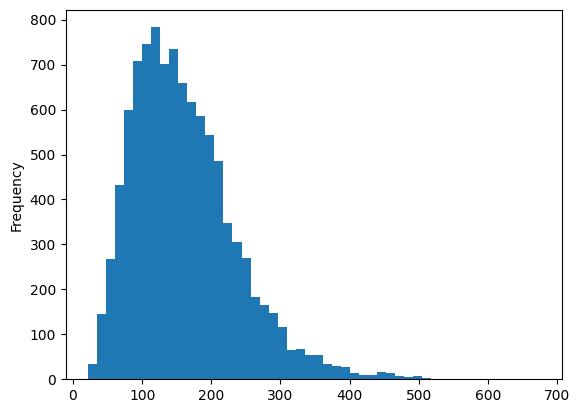

In [13]:
data_raw['contents'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [14]:
doc = nlp(data_raw.iloc[0]['contents'])

Only the Alphanumeric words are important, whitespace, punctuation and stop words should be excluded.

In [15]:
def token_to_df(doc=doc):
    token_info = []
    for token in doc:
        token_info.append({
            "Text": token.text,
            "Index": token.idx,
            "Whitespace": token.is_space,
            "Is Alphanumeric?": token.is_alpha,
            "Is Punctuation?": token.is_punct,
            "Is Stop Word?": token.is_stop
        })
    return pd.DataFrame(token_info)

token_to_df(doc)

,Text,Index,Whitespace,Is Alphanumeric?,Is Punctuation?,Is Stop Word?
0,[,0,False,False,True,False
1,Biochemical,1,False,True,False,False
2,studies,13,False,True,False,False
3,on,21,False,True,False,True
4,camomile,24,False,True,False,False
...,...,...,...,...,...,...
98,inhibiting,509,False,True,False,False
99,effect,520,False,True,False,False
100,is,527,False,True,False,True
101,lost,530,False,True,False,False


Lemmatization is necessary to reduce the length of the content while preserving relevant information.

In [16]:
for token in doc:
    if str(token) != str(token.lemma_):
        print(f"{str(token):>20} : {str(token.lemma_)}")

         Biochemical : biochemical
             studies : study
          components : component
                  In : in
             studies : study
                 has : have
           depending : depend
                  is : be
              caused : cause
                  pH : ph
                 The : the
                  is : be
             reduced : reduce
                 The : the
              occurs : occur
                  In : in
          inhibiting : inhibit
                  is : be
                lost : lose


In [17]:
def clean_text(text):
    complete_doc = nlp(text)
    words = [token.text for token in complete_doc 
             if token.is_alpha and not token.is_stop and not token.is_punct]
    return ' '.join(words)

def lemmalize_text(text):
    complete_doc = nlp(text)
    words = [token.lemma_ for token in complete_doc]
    return ' '.join(words)

In [18]:
text = data_raw.iloc[0]['contents']
text = clean_text(text)
text = lemmalize_text(text)
clean_doc = nlp(text)

After cleaning, the first contents length is reduced from 103 to 44.

In [19]:
token_to_df(clean_doc).shape[0]

44

Tokenization

In [20]:
def tokenized_text(text):
    complete_doc = nlp(text)
    words = [token.text.lower() for token in complete_doc]
    return words

Overall Cleaning Process(Takes 2.5 minutes to run)

In [21]:
def full_preprocessing(text):
    text = clean_text(text)
    text = lemmalize_text(text)
    text = tokenized_text(text)
    return ' '.join(text)

In [22]:
data_clean = data_raw.copy()
data_clean['cleaned'] = data_raw['contents'].transform(full_preprocessing)

After cleaning, the contents length ranges from 14 to 267, with the mean of 90. 

In [23]:
print("Min Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 14
Max Length: 303
Mean Length:90.8452


<Axes: ylabel='Frequency'>

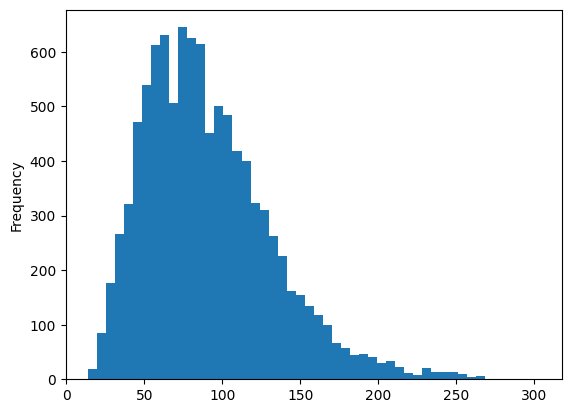

In [24]:
data_clean['cleaned'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [25]:
data_clean.to_csv('train_clean.csv', index=False)

### 3. Generate test dataset

In [26]:
import random
import pandas as pd

# Load your dataset of papers
papers = pd.read_csv("train_clean.csv")

# Randomly select 100 papers
test_data = papers.sample(n=100, random_state=123)

# Display the first few rows of the selected test data
test_data.head()

,id,title,content,contents,PMID,cleaned
2656,pubmed23n0001_2656,Suppression and stimulation mechanisms control...,The mechanisms controlling secretion of glucag...,Suppression and stimulation mechanisms control...,5326,suppression stimulation mechanism control gluc...
445,pubmed23n0001_445,Value of capillary blood gas analyses in the m...,A comparative study of blood gases and acid-ba...,Value of capillary blood gas analyses in the m...,936,value capillary blood gas analyse management a...
9505,pubmed23n0001_9505,"Bufuralol, a new beta-adrenoceptor blocking ag...",The synthesis and resolution of a new beta-adr...,"Bufuralol, a new beta-adrenoceptor blocking ag...",18158,bufuralol new beta adrenoceptor block agent sy...
332,pubmed23n0001_332,The determination of gamma-glutamyl transpepti...,The determination of gamma-glutamyl transpepti...,The determination of gamma-glutamyl transpepti...,646,determination gamma glutamyl transpeptidase re...
4168,pubmed23n0001_4168,Effects of autonomic drugs on epididymal contr...,The spontaneous contractility of rat epididymi...,Effects of autonomic drugs on epididymal contr...,8341,effect autonomic drug epididymal contraction s...


In [27]:
import ollama
# Function to generate a query based on the paper's title
def generate_query(contents, max_length=200, temperature=0.2):
    prompt = f"""
Based on the following paper contents, generate a natural-language query that a user might ask to find this paper.

Paper:
\"\"\"
{contents}
\"\"\"

The output should ONLY include the query content, starting naturally like:
"I want to find research about..." or "What are studies about..."

Do not include any explanation or formatting. Only the query.
"""

    client = ollama.Client()

    model = "llama3.2"

    response = client.generate(
        model=model,
        prompt=prompt,
        options={"temperature": temperature}
    )
    
    return response.response[:max_length].strip()

test_data = test_data.assign(generated_query = test_data['cleaned'].apply(generate_query))
pd.set_option('display.max_colwidth', 200)
test_data.head().loc[:, ['PMID', 'generated_query']]


,PMID,generated_query
2656,5326,"I want to find research about the suppression stimulation mechanism control of glucagon secretion in patients with islet cell tumors and its effects on multihormone secretion during fasting, gluco..."
445,936,I want to find research about comparing blood gas analysis management in patients with acute respiratory distress and circulatory shock using capillary samples versus arterial finger pricks.
9505,18158,"I want to find research about a new beta adrenoceptor block agent called bufuralol, including its synthesis, structure, activity, and potential lead compounds."
332,646,I want to find research about gamma glutamyl transpeptidase reaction rate assay conditions and optimal settings for analysis.
4168,8341,I want to find research about the effects of autonomic drugs on spontaneous contraction in the rat epididymis and how different blockers affect norepinephrine and acetylcholine.


In [28]:
test_data.to_csv("test.csv", index=False)

### 4. Bi-encoder Implementation and Evaluation

In [29]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('train_clean.csv')
data_str = data['cleaned'].tolist()

# Load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')

# Encode the dataset
embeddings = model.encode(data_str)

torch.save(embeddings, 'embeddings.pt')

In [30]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")
embeddings = torch.load('embeddings.pt', weights_only=False)

query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"

# Preprocess the query
query_new = full_preprocessing(query)

# Encode the query
query_embedding = model.encode([query_new])

# Compute similarities
similarities = model.similarity(query_embedding, embeddings)

# Get the top `n` most similar papers
similarities_tensor = torch.tensor(similarities)
top_n_values, top_n_indices = torch.topk(similarities_tensor, 10)
top_n_indices = top_n_indices.tolist()[0]

scores = top_n_values.squeeze().tolist()
indices = top_n_indices

for i, (score, idx) in enumerate(zip(scores, indices)):
    print(f"{i+1}. Index: {idx} | Similarity: {score:.4f}")


1. Index: 9027 | Similarity: 0.5555
2. Index: 0 | Similarity: 0.5420
3. Index: 2083 | Similarity: 0.5378
4. Index: 139 | Similarity: 0.5259
5. Index: 8962 | Similarity: 0.5015
6. Index: 9732 | Similarity: 0.5010
7. Index: 1592 | Similarity: 0.4970
8. Index: 2531 | Similarity: 0.4931
9. Index: 5918 | Similarity: 0.4868
10. Index: 9054 | Similarity: 0.4859


In [31]:
# Load the original dataset to retrieve paper details
top_k_papers = data.iloc[top_n_indices]

top_k_papers

,id,title,content,contents,PMID,cleaned
9027,pubmed23n0001_9027,[Peptic ulcer: new aspects of conservative therapy].,"In spite of the large number of preparations, medical therapy of peptic ulcer disease has long been unsatisfactory. Antacids, anticholinergics and diet neither accelerate healing of ulcers nor pre...","[Peptic ulcer: new aspects of conservative therapy]. In spite of the large number of preparations, medical therapy of peptic ulcer disease has long been unsatisfactory. Antacids, anticholinergics ...",17157,peptic ulcer new aspect conservative therapy spite large number preparation medical therapy peptic ulcer disease long unsatisfactory antacids anticholinergic diet accelerate healing ulcer prevent ...
0,pubmed23n0001_0,[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)].,"(--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through ...",[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action dep...,21,biochemical study camomile component iii vitro study antipeptic activity bisabolol author transl bisabolol primary antipeptic action depend dosage cause alteration ph value proteolytic activity pe...
2083,pubmed23n0001_2083,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats.,The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acetylphenothiazine (SAS) has been investigated. At 10 and 20 mg/kg (s.c.) the drug was found to po...,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats. The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acet...,4186,effect sas new n acylaminophenothiazine gastric secretion ulceration rat antiulcer antisecretory activity beta hydroxyethyl acetylphenothiazine sas investigate mg kg drug find possess potent antig...
139,pubmed23n0001_139,[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats].,"Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was completely blocked by pretreatment with alpha-blockers (phenoxybenzamine, dibena...","[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats]. Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was co...",278,biphasic ulcer forming ulcer prevent effect adrenaline rat adrenaline induce gastric ulceration study rat adrenaline high dose cause gastric ulcer completely block pretreatment alpha blocker pheno...
8962,pubmed23n0001_8962,Measurement of prostaglandin E2 in an inflammatory exudate: effects of nonsteroidal anti-inflammatory agents.,"A method was developed for extracting and measuring nanogram quantities of prostaglandin E2 (PGE2) from carrageenan-induced abscess in the rat. PGE2 concentration, quantitated by radioimmunoassay,...",Measurement of prostaglandin E2 in an inflammatory exudate: effects of nonsteroidal anti-inflammatory agents. A method was developed for extracting and measuring nanogram quantities of prostagland...,17001,measurement prostaglandin inflammatory exudate effect nonsteroidal anti inflammatory agent method develop extract measure nanogram quantity prostaglandin carrageenan induce abscess rat concentrati...
9732,pubmed23n0001_9732,"The pharmacology of benoxaprofen (2-[4-chlorophenyl]-alpha-methyl-5-benzoxazole acetic acid), LRCL 3794, a new compound with antiinflammatory activity apparently unrelated to inhibition of prostag...","Benoxaprofen is a potent and long-acting anti-inflammatory and antipyretic compound. Its anti-inflammatory ac

In [32]:
def BI_encoder(query, k=10, embeddings=embeddings, model=model):

    # Preprocess the query
    query_new = full_preprocessing(query)

    # Encode the query
    query_embedding = model.encode([query_new])

    # Compute similarities
    similarities = model.similarity(query_embedding, embeddings)

    # Get the top `n` most similar papers
    similarities_tensor = torch.tensor(similarities)
    top_n_values, top_n_indices = torch.topk(similarities_tensor, k)
    top_n_indices = top_n_indices.tolist()[0]

    top_k_papers = data.iloc[top_n_indices]

    return top_k_papers

Start testing...
All papers have been tested.
Accuracy: 0.9200
Time Mean: 0.0167
Time Std: 0.0018
Time Max: 0.0247
Time Min: 0.0137


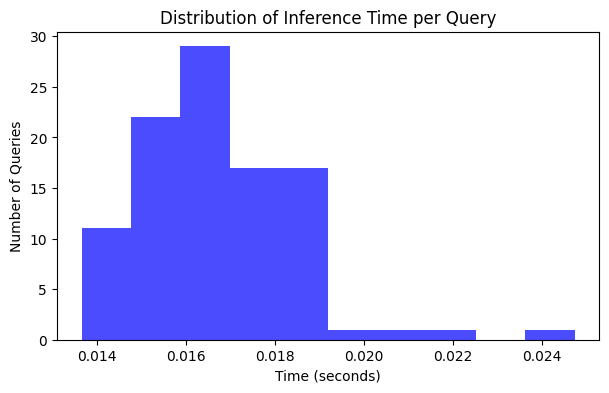

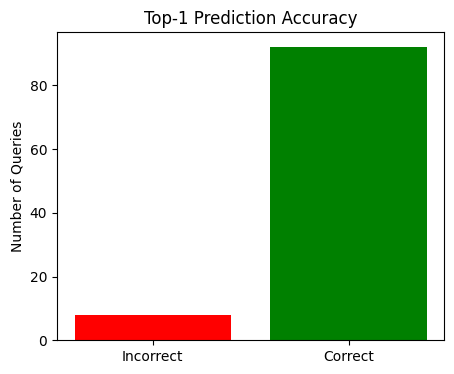

Test result saved to BI_test_result.csv


In [33]:
import time
import matplotlib.pyplot as plt

def BI_time_test(test_df):
    k = 1
    test_result = test_df.copy()
    test_result['top PMID'] = None
    test_result['Time'] = None
    test_result['hit'] = None
    embeddings = torch.load('embeddings.pt', weights_only=False)
    model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')

    print("Start testing...")
    for _, row in test_df.iterrows():
        start_time = time.time()
        query = row['generated_query']

        # Get the top 1 most similar papers
        top_results = BI_encoder(query, k=k, embeddings=embeddings, model=model)
        end_time = time.time()

        test_result.loc[_, 'top PMID'] = top_results['PMID'].iloc[0]
        test_result.loc[_, 'Time'] = end_time - start_time
        test_result.loc[_, 'hit'] = 1 if test_result.loc[_, 'top PMID'] == row['PMID'] else 0
    print("All papers have been tested.")

    accuracy = test_result['hit'].mean()
    time_mean = test_result['Time'].mean()
    time_std = test_result['Time'].std()
    time_max = test_result['Time'].max()
    time_min = test_result['Time'].min()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Time Mean: {time_mean:.4f}")
    print(f"Time Std: {time_std:.4f}")
    print(f"Time Max: {time_max:.4f}")
    print(f"Time Min: {time_min:.4f}")

    plt.figure(figsize=(7, 4))
    plt.hist(test_result['Time'], bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Inference Time per Query')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Queries')
    plt.show()

    hit_counts = test_result['hit'].value_counts()
    plt.figure(figsize=(5, 4))
    plt.bar(['Incorrect', 'Correct'], hit_counts.sort_index(), color=['red', 'Green'])
    plt.title('Top-1 Prediction Accuracy')
    plt.ylabel('Number of Queries')
    plt.show()

    test_result.to_csv('BI_test_result.csv', index=False)
    print("Test result saved to BI_test_result.csv")

test_df = pd.read_csv('test.csv')   
BI_time_test(test_df)

### 5. Cross encoder Implementation and Evaluation

In [34]:
from sentence_transformers import CrossEncoder
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

def CROSS_encoder(query, k=10, dataset=None, model=None):

    data_list = dataset['cleaned'].tolist()

    query_new = full_preprocessing(query)

    # Create query-document pairs
    cross_input = [[query_new, doc] for doc in data_list]

    # Predict similarity scores
    scores = model.predict(cross_input)

    # Get the top-k highest scoring documents
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_scores = [scores[i] for i in top_k_indices]

    # Retrieve corresponding rows from the dataset
    top_k_papers = dataset.iloc[top_k_indices].copy()
    top_k_papers['cross_encoder_score'] = top_k_scores

    reranked_papers = top_k_papers.sort_values(by='cross_encoder_score', ascending=False)

    return reranked_papers

In [35]:
query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"
dataset = pd.read_csv('train_clean.csv')
k = 10
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
CROSS_encoder(query, k=k, dataset=dataset, model=model)

,id,title,content,contents,PMID,cleaned,cross_encoder_score
0,pubmed23n0001_0,[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)].,"(--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through ...",[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action dep...,21,biochemical study camomile component iii vitro study antipeptic activity bisabolol author transl bisabolol primary antipeptic action depend dosage cause alteration ph value proteolytic activity pe...,0.736629
139,pubmed23n0001_139,[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats].,"Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was completely blocked by pretreatment with alpha-blockers (phenoxybenzamine, dibena...","[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats]. Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was co...",278,biphasic ulcer forming ulcer prevent effect adrenaline rat adrenaline induce gastric ulceration study rat adrenaline high dose cause gastric ulcer completely block pretreatment alpha blocker pheno...,-2.403787
4794,pubmed23n0001_4794,[In vitro antibacterial effects of spectinomycin and penicillin G on Neisseria gonorrhoeae singly and in combination (author's transl)].,The antibacterial effects of spectinomycin and penicillin G on clinical isolates of Neisseria gonorrhoeae were studied. The concentrations of penicillin G at which the isolates showed drug sensiti...,[In vitro antibacterial effects of spectinomycin and penicillin G on Neisseria gonorrhoeae singly and in combination (author's transl)]. The antibacterial effects of spectinomycin and penicillin G...,9523,vitro antibacterial effect spectinomycin penicillin g neisseria gonorrhoeae singly combination author transl antibacterial effect spectinomycin penicillin g clinical isolate neisseria gonorrhoeae ...,-3.185714
2083,pubmed23n0001_2083,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats.,The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acetylphenothiazine (SAS) has been investigated. At 10 and 20 mg/kg (s.c.) the drug was found to po...,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats. The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acet...,4186,effect sas new n acylaminophenothiazine gastric secretion ulceration rat antiulcer antisecretory activity beta hydroxyethyl acetylphenothiazine sas investigate mg kg drug find possess potent antig...,-3.368822
9428,pubmed23n0001_9428,"Effects of cimetidine, a histamine H2-receptor antagonist, on various experimental gastric and duodenal ulcers.","The effects of cimetidine, a new histamine H2-receptor antagonist, on the development of experimental gastric and duodenal ulcers were studied. It was found that either by the oral, intraduodenal,...","Effects of cimetidine, a histamine H2-receptor antagonist, on various experimental gastric and duodenal ulcers. The effects of cimetidine, a new histamine H2-receptor antagonist, on the developmen...",18007,effect cimetidine histamine receptor antagonist experimental gastric duodenal ulcer effect cimetidine new histamine receptor antagonist development experimental gastric duodenal ulcer study find o...,-3.411642
4868,pubmed23n0001_4868,Studies on the action mechanism of the antihemostatic effect of lodopeptides.,A synthetic iodopeptide having a glutamic acid-diiodotyrosine molar ratio of 1:1

Start testing...
All papers have been tested.
Accuracy: 1.0000
Time Mean: 21.6735
Time Std: 0.4688
Time Max: 22.9641
Time Min: 20.3698


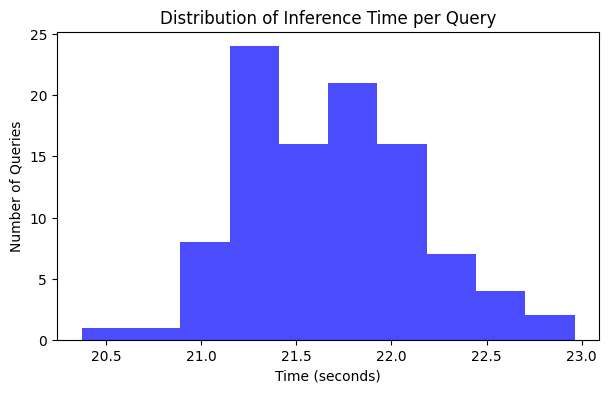

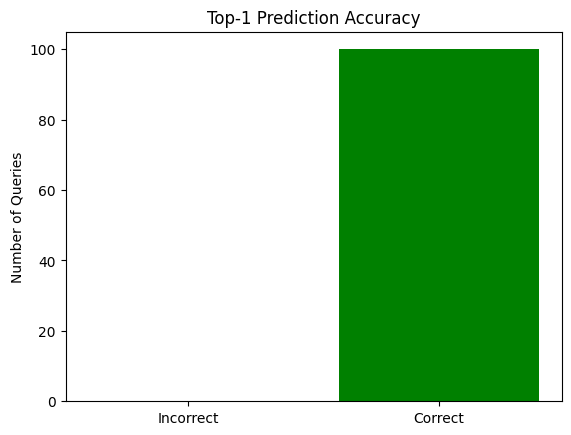

Test result saved to Cross_test_result.csv


In [36]:
import time
import matplotlib.pyplot as plt

def CROSS_time_test(test_df):
    k = 1
    dataset = pd.read_csv('train_clean.csv')
    test_result = test_df.copy()
    test_result['top PMID'] = None
    test_result['Time'] = None
    test_result['hit'] = None
    model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

    print("Start testing...")
    for _, row in test_df.iterrows():
        start_time = time.time()
        query = row['generated_query']

        # Get the top 1 most similar papers
        top_results = CROSS_encoder(query, k=k, dataset=dataset, model=model)
        end_time = time.time()

        test_result.loc[_, 'top PMID'] = top_results['PMID'].iloc[0]
        test_result.loc[_, 'Time'] = end_time - start_time
        test_result.loc[_, 'hit'] = 1 if test_result.loc[_, 'top PMID'] == row['PMID'] else 0
    print("All papers have been tested.")

    accuracy = test_result['hit'].mean()
    time_mean = test_result['Time'].mean()
    time_std = test_result['Time'].std()
    time_max = test_result['Time'].max()
    time_min = test_result['Time'].min()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Time Mean: {time_mean:.4f}")
    print(f"Time Std: {time_std:.4f}")
    print(f"Time Max: {time_max:.4f}")
    print(f"Time Min: {time_min:.4f}")

    plt.figure(figsize=(7, 4))
    plt.hist(test_result['Time'], bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Inference Time per Query')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Queries')
    plt.show()

    hit_counts = test_result['hit'].value_counts().reindex([0, 1], fill_value=0)
    plt.bar(['Incorrect', 'Correct'], hit_counts.sort_index(), color=['red', 'Green'])
    plt.title('Top-1 Prediction Accuracy')
    plt.ylabel('Number of Queries')
    plt.show()

    test_result.to_csv('CROSS_test_result.csv', index=False)
    print("Test result saved to Cross_test_result.csv")

test_df = pd.read_csv('test.csv')   
CROSS_time_test(test_df)

### 6. Combination of Bi-encoder and Cross Encoder

In [52]:
from sentence_transformers import SentenceTransformer, CrossEncoder
import pandas as pd
import torch

bi_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
embeddings = torch.load('embeddings.pt', weights_only=False)

def Merge_encoder(query, k=10, embeddings=embeddings, bi_model=bi_model, cross_model=cross_model):

    # Load the original dataset to retrieve paper details
    dataset = BI_encoder(query, k=k, embeddings=embeddings, model=bi_model)

    top_k_papers = CROSS_encoder(query, k=k, dataset=dataset, model=cross_model)

    return top_k_papers.iloc[:5]

In [53]:
bi_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
embeddings = torch.load('embeddings.pt', weights_only=False)
query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"
k = 10
Merge_encoder(query, k=k, embeddings=embeddings, bi_model=bi_model, cross_model=cross_model)

,id,title,content,contents,PMID,cleaned,cross_encoder_score
0,pubmed23n0001_0,[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)].,"(--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through ...",[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action dep...,21,biochemical study camomile component iii vitro study antipeptic activity bisabolol author transl bisabolol primary antipeptic action depend dosage cause alteration ph value proteolytic activity pe...,0.736629
139,pubmed23n0001_139,[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats].,"Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was completely blocked by pretreatment with alpha-blockers (phenoxybenzamine, dibena...","[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats]. Adrenaline-induced gastric ulceration was studied in rats. Adrenaline in high doses caused gastric ulcer, which was co...",278,biphasic ulcer forming ulcer prevent effect adrenaline rat adrenaline induce gastric ulceration study rat adrenaline high dose cause gastric ulcer completely block pretreatment alpha blocker pheno...,-2.403787
2083,pubmed23n0001_2083,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats.,The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acetylphenothiazine (SAS) has been investigated. At 10 and 20 mg/kg (s.c.) the drug was found to po...,Effect of SAS (a new 10-N-acylaminophenothiazine) on gastric secretion and ulceration in rats. The antiulcer and antisecretory activity of 2-chloro-10-[4'(N-beta-hydroxyethyl) piperazinyl-1'] acet...,4186,effect sas new n acylaminophenothiazine gastric secretion ulceration rat antiulcer antisecretory activity beta hydroxyethyl acetylphenothiazine sas investigate mg kg drug find possess potent antig...,-3.368822
9027,pubmed23n0001_9027,[Peptic ulcer: new aspects of conservative therapy].,"In spite of the large number of preparations, medical therapy of peptic ulcer disease has long been unsatisfactory. Antacids, anticholinergics and diet neither accelerate healing of ulcers nor pre...","[Peptic ulcer: new aspects of conservative therapy]. In spite of the large number of preparations, medical therapy of peptic ulcer disease has long been unsatisfactory. Antacids, anticholinergics ...",17157,peptic ulcer new aspect conservative therapy spite large number preparation medical therapy peptic ulcer disease long unsatisfactory antacids anticholinergic diet accelerate healing ulcer prevent ...,-4.288044
9054,pubmed23n0001_9054,Drugs for peptic ulcer.,"Conservative management of peptic ulcer relies on the use of drugs as an adjuvant to the time-honored measures of avoiding stress, reducing gastric secretion, and regulating the diet. Alkalies neu...","Drugs for peptic ulcer. Conservative management of peptic ulcer relies on the use of drugs as an adjuvant to the time-honored measures of avoiding stress, reducing gastric secretion, and regulatin...",17229,drug peptic ulcer conservative management peptic ulcer relie use drug adjuvant time honor measure avoid stress reduce gastric secretion regulating diet alkalies neutralize acid anticholinergic dru...,-5.465942


Start testing...
All papers have been tested.
Accuracy: 0.9900
Time Mean: 0.0425
Time Std: 0.0071
Time Max: 0.0774
Time Min: 0.0329


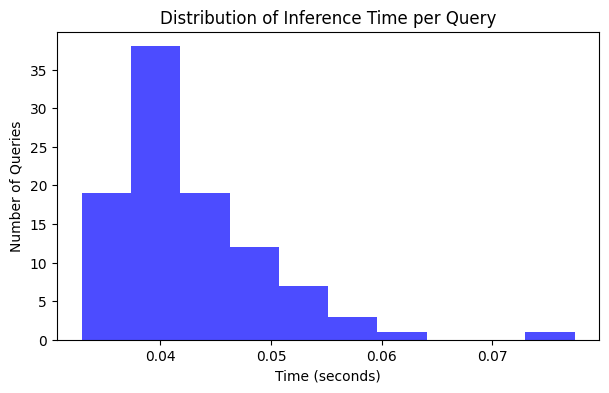

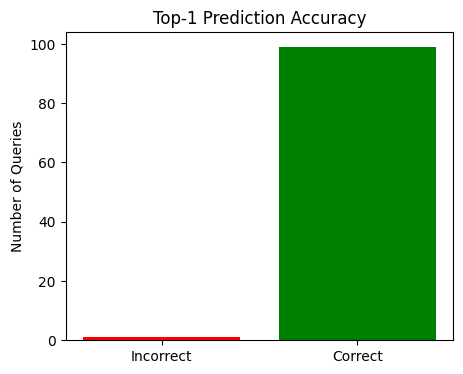

Test result saved to Merge_test_result.csv


In [54]:
import time
import matplotlib.pyplot as plt

def Merge_time_test(test_df):
    k = 10
    test_result = test_df.copy()
    test_result['top PMID'] = None
    test_result['Time'] = None
    test_result['hit'] = None

    bi_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
    cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
    embeddings = torch.load('embeddings.pt', weights_only=False)

    print("Start testing...")
    for _, row in test_df.iterrows():
        start_time = time.time()
        query = row['generated_query']

        # Get the top 1 most similar papers
        top_results = Merge_encoder(query, k=k, embeddings=embeddings, bi_model=bi_model, cross_model=cross_model)
        end_time = time.time()

        test_result.loc[_, 'top PMID'] = top_results['PMID'].iloc[0]
        test_result.loc[_, 'Time'] = end_time - start_time
        test_result.loc[_, 'hit'] = 1 if test_result.loc[_, 'top PMID'] == row['PMID'] else 0
    print("All papers have been tested.")

    accuracy = test_result['hit'].mean()
    time_mean = test_result['Time'].mean()
    time_std = test_result['Time'].std()
    time_max = test_result['Time'].max()
    time_min = test_result['Time'].min()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Time Mean: {time_mean:.4f}")
    print(f"Time Std: {time_std:.4f}")
    print(f"Time Max: {time_max:.4f}")
    print(f"Time Min: {time_min:.4f}")

    plt.figure(figsize=(7, 4))
    plt.hist(test_result['Time'], bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Inference Time per Query')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Queries')
    plt.show()

    hit_counts = test_result['hit'].value_counts()
    plt.figure(figsize=(5, 4))
    plt.bar(['Incorrect', 'Correct'], hit_counts.sort_index(), color=['red', 'Green'])
    plt.title('Top-1 Prediction Accuracy')
    plt.ylabel('Number of Queries')
    plt.show()

    test_result.to_csv('Merge_test_result.csv', index=False)
    print("Test result saved to Merge_test_result.csv")

test_df = pd.read_csv('test.csv')   
Merge_time_test(test_df)

### 7. Calling LLM to generate result

In [57]:
import re
import ollama
def call_llm(rank_papers, query, temperature=0.4):

    rank_list = zip(rank_papers['PMID'], rank_papers['title'], rank_papers['content'])

    client = ollama.Client()

    model = "medical-paper"

    prompt = f"""
    You are a medical paper recommendation assistant. 
    Your task is to recommend relevant medical papers based on user's requirement.
    Here is the topic user interested in: {query}
    Below are the top 5 most relevant papers that I found from my database. Give your reconmmendation only based on these information.
    """

    prompt += f"""
    Please refer to the papers using their exact Title and url from this list.
    Do not invent new titles or URLs.

    Available papers:"""

    i = 1
    for pmid, title, content in rank_list:
        prompt += f"""\n
      [{i}] Title: {title}
            URL: https://pubmed.ncbi.nlm.nih.gov/{pmid}/
            Content: {content}
    \n"""
        i += 1
        
    prompt += f"""
    After reading the papers, reconmmend most relevant 2 papers **from the list above**.
    You MUST:
    - Use the exact Title and URL as given above.
    - Do NOT make up new titles or PMIDs.
    - Do NOT recommend any paper that was not listed above, no duplicate reconmmendation.
    - Only use the information provided above for your recommendation.
    """

    prompt += f"""
    Below is the example of the format you should follow, you must follow this format:
    ---
    Paper 1:
    - Title: "[Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats]"  
    - URL: [PubMed Link](https://pubmed.ncbi.nlm.nih.gov/278/)  
    - Summary: This study explores the dual effects of adrenaline on gastric ulcers in rats, showing that high doses cause ulcers while lower doses prevent them. The mechanism involves alpha-adrenergic action and tachyphlaxis.  
    - Why I recommend this paper: It offers valuable insights into the mechanisms behind ulcer formation and prevention, providing context for understanding natural products' potential therapeutic effects.
    ---
    """
    

    response = client.generate(model=model, 
                               prompt=prompt,
                               options={"temperature": temperature})

    def remove_think_section(response_text):
        pattern = r"<think>.*?</think>" 
        cleaned_text = re.sub(pattern, "", response_text, flags=re.DOTALL) 
        return cleaned_text.strip()
    
    cleaned_response = remove_think_section(response.response)
    
    return cleaned_response

In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch

bi_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
embeddings = torch.load('embeddings.pt', weights_only=False)
query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"
k = 10

rank_papers = Merge_encoder(query, k=k, embeddings=embeddings, bi_model=bi_model, cross_model=cross_model).iloc[:5]

print(call_llm(rank_papers, query))

Result:
Prompt:

    You are a medical paper recommendation assistant. 
    Your task is to recommend relevant medical papers based on user's requirement.
    Here is the topic user interested in: What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?
    Below are the top 5 most relevant papers that I found from my database. Give your reconmmendation based on these information.
    
    Please refer to the papers using their exact Title and url from this list.
    Do not invent new titles or URLs.

    Available papers:

      [1] Title: [Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)].
            URL: https://pubmed.ncbi.nlm.nih.gov/21/
            Content: (--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is

### 8. Final Command Line User Interface

In [47]:
bi_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
embeddings = torch.load('embeddings.pt', weights_only=False)
k = 10

In [59]:
from datetime import datetime

def main():
    print("Welcome to the Medical Paper Recommendation Assistant!")
    print("Type your query below (or type 'exit' to quit):")

    while True:
        # Get user input
        user_query = input("\nEnter your query: ").strip()
        if user_query.lower() == "exit":
            print("Goodbye!")
            break

        # Start timing
        start_time = datetime.now()
        print(f"\nProcessing your query... (Start Time: {start_time})")

        rank = Merge_encoder(user_query, k=k, embeddings=embeddings, bi_model=bi_model, cross_model=cross_model).iloc[:5]

        print(call_llm(rank, user_query))

        # End timing
        end_time = datetime.now()
        print(f"\nEnd Time: {end_time}")
        print(f"Execution Time: {end_time - start_time}")

if __name__ == "__main__":
    main()

Welcome to the Medical Paper Recommendation Assistant!
Type your query below (or type 'exit' to quit):

Processing your query... (Start Time: 2025-04-08 21:56:33.981857)
---

**Paper 1:**
- **Title:** Bufuralol, a new beta-adrenoceptor blocking agent. Part 1: synthesis and structure-activity studies in a series of benzofuran-2-ethanolamines.
- **URL:** https://pubmed.ncbi.nlm.nih.gov/18158/
- **Summary:** This study details the synthesis and resolution of bufralol, including structure-activity studies that led to its selection as a beta-blocker. It provides foundational information on bufralol's properties.
- **Why I recommend this paper:** It directly addresses bufralol's synthesis and activity, fulfilling key aspects of the user’s query.

**Paper 4:**
- **Title:** Biphasic (ulcer-forming and ulcer-preventing) effect of adrenaline in rats
- **URL:** https://pubmed.ncbi.nlm.nih.gov/278/
- **Summary:** This study explores adrenaline's dual effects on gastric ulcers, involving alpha-adre